In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import heapq
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec

/usr/local/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
query = """ 
    select dq.event_date, c.label, dq.close_value
    from company c
    inner join daily_quote dq on c.id = dq.company_id
    where ibovespa_plus = true 
    and (now() - dq.event_date) <= interval '4.5 months'
    order by dq.event_date, c.label;"""

In [3]:
conn = psycopg2.connect(
            database="postgres",
            user="postgres",
            connect_timeout=3,
            options='-c statement_timeout=3000')
raw_df = pd.read_sql(query, conn)
conn.close()

In [4]:
raw_df.columns = ['Data', 'Sigla', 'Valor_de_Fechamento']
raw_df.set_index(['Data', 'Sigla'], inplace=True)

In [5]:
df = (raw_df.unstack()
          .dropna(axis=1))
df = df.loc[:, 'Valor_de_Fechamento'].copy()

In [6]:
df.head(5)

Sigla,ABCB4,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,...,TIMP3,TRPL4,UGPA3,UNIP3,UNIP6,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-10-22,15.54,16.82,39.85,28.93,33.25,26.53,34.39,20.62,53.40,11.67,...,11.05,61.15,39.79,34.4208,38.5550,10.45,58.37,38.42,4.84,18.65
2018-10-23,15.67,16.63,39.99,29.01,33.37,26.35,33.60,20.54,52.90,11.71,...,11.02,61.32,40.01,33.6875,37.3908,10.20,56.75,38.45,5.35,19.20
2018-10-24,15.50,15.89,39.10,28.19,32.57,25.75,32.30,20.13,51.12,11.42,...,10.68,61.24,39.18,33.9442,37.7667,9.70,54.43,37.52,5.00,19.35
2018-10-25,15.80,15.00,40.10,29.40,33.51,26.36,32.88,20.15,50.66,11.68,...,10.75,61.29,41.31,34.1000,38.3625,9.90,54.61,38.00,5.30,19.01
2018-10-26,15.70,15.19,42.42,29.73,34.09,26.03,33.34,20.48,49.90,12.00,...,10.63,62.22,42.50,34.3292,38.5000,10.06,55.60,37.97,5.38,18.08


In [7]:
df.describe()

Sigla,ABCB4,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,...,TIMP3,TRPL4,UGPA3,UNIP3,UNIP6,USIM5,VALE3,VIVT4,VVAR3,WEGE3
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,17.426092,16.896897,46.883908,35.430000,39.892184,27.954713,31.151494,22.291379,51.342414,13.063218,...,11.967931,72.041379,50.001839,37.329093,37.857652,9.623563,50.945977,46.275402,5.043563,18.380345
std,1.285086,1.069071,4.264939,3.567055,3.801873,1.344908,2.552033,1.213815,3.019906,0.786283,...,0.474849,5.032534,5.361695,1.718350,1.688468,0.426593,4.348682,2.681984,0.462885,0.697775
min,15.500000,15.000000,39.100000,28.190000,32.570000,25.750000,26.200000,19.770000,46.290000,11.410000,...,10.630000,61.150000,39.180000,33.687500,33.825000,8.530000,41.590000,37.520000,4.010000,16.830000
25%,16.425000,16.105000,43.680000,32.880000,37.040000,26.960000,28.875000,21.615000,48.340000,12.635000,...,11.730000,67.835000,45.565000,36.322950,36.809150,9.355000,47.045000,45.825000,4.710000,17.960000
50%,16.950000,16.630000,45.760000,34.380000,38.840000,27.680000,31.400000,22.260000,52.080000,13.140000,...,11.980000,72.680000,50.540000,37.400000,37.583300,9.700000,51.440000,46.900000,5.050000,18.460000
75%,18.510000,17.975000,50.120000,38.675000,43.210000,28.565000,33.200000,23.100000,54.040000,13.555000,...,12.290000,77.065000,54.370000,38.057500,39.430000,9.910000,54.480000,47.900000,5.365000,18.865000
max,20.100000,18.750000,54.810000,41.340000,46.300000,31.620000,35.380000,25.320000,56.030000,14.510000,...,12.990000,79.500000,58.190000,40.500000,41.525000,10.450000,58.370000,49.200000,6.000000,19.790000


In [8]:
column_names = df.columns.values
for cn in column_names:
    df[cn] = (df[cn] / df[cn].shift(1) - 1).fillna(0)    

In [9]:
df.head(5)

Sigla,ABCB4,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,...,TIMP3,TRPL4,UGPA3,UNIP3,UNIP6,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-10-23,0.008366,-0.011296,0.003513,0.002765,0.003609,-0.006785,-0.022972,-0.003880,-0.009363,0.003428,...,-0.002715,0.002780,0.005529,-0.021304,-0.030196,-0.023923,-0.027754,0.000781,0.105372,0.029491
2018-10-24,-0.010849,-0.044498,-0.022256,-0.028266,-0.023974,-0.022770,-0.038690,-0.019961,-0.033648,-0.024765,...,-0.030853,-0.001305,-0.020745,0.007620,0.010053,-0.049020,-0.040881,-0.024187,-0.065421,0.007813
2018-10-25,0.019355,-0.056010,0.025575,0.042923,0.028861,0.023689,0.017957,0.000994,-0.008998,0.022767,...,0.006554,0.000816,0.054364,0.004590,0.015776,0.020619,0.003307,0.012793,0.060000,-0.017571
2018-10-26,-0.006329,0.012667,0.057855,0.011224,0.017308,-0.012519,0.013990,0.016377,-0.015002,0.027397,...,-0.011163,0.015174,0.028807,0.006721,0.003584,0.016162,0.018129,-0.000789,0.015094,-0.048922


In [10]:
means = np.mean(df)
covariance_matrix = np.cov(df, rowvar=False)

In [11]:
def risk_profit(a):
    return np.sqrt(np.dot(np.dot(a, covariance_matrix), a)), np.sum(np.multiply(a, means))

### Função multi-objetivo
A função f tentará minimizar a variancia da carteira e maximizar o seu retorno

In [12]:
def f(x):
    # return 1.0 / np.sum(np.multiply(x, means)) # maximiza o lucro
    # return np.dot(np.dot(x, covariance_matrix), x) # minimiza o risco
    return (np.dot(x.T, np.dot(covariance_matrix, x))) / np.sum(np.multiply(x, means)) # 2nd version
    #return np.dot(np.dot(x, covariance_matrix), x) / np.sum(np.multiply(x, means))

SLSQP - Sequential Least Squares Programming

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. [Kraft1988] [LICENSE]

http://www.pyopt.org/reference/optimizers.slsqp.html

In [13]:
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
n = df.shape[1]
x0 = np.random.rand(n) # gera n valores aleatórios
x0 = x0 / np.sum(x0) # padroniza os valores de moro que a soma seja igual a 1.0
result = minimize(f, x0, constraints=cons, method='SLSQP', options={'disp': 'True', 'maxiter': 1000})
# result = minimize(f, x0, method='Powell', options={'disp': 'True', 'maxiter': 100})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0011126881858068715
            Iterations: 78
            Function evaluations: 6320
            Gradient evaluations: 78


### Representação visual da carteira otimizada!

risk=0.002011318382045771, profit=0.003635701075608782


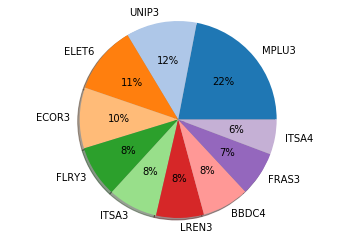

[0.5781420164620495, 0.30601518047194204, 0.2933064199563944, 0.2627061311533546, 0.2226088480392374, 0.2152962655976803, 0.2061599195855198, 0.20280041227744525, 0.19291287989790998, 0.15094545089133413]
['MPLU3', 'UNIP3', 'ELET6', 'ECOR3', 'FLRY3', 'ITSA3', 'LREN3', 'BBDC4', 'FRAS3', 'ITSA4']


In [14]:
from matplotlib import cm
diff_companies = 10
cm = plt.cm.get_cmap('tab20')
optimal_values = []
optimized = result.success
if optimized:
    risk, profit = risk_profit(result.x)
    print("risk=%s, profit=%s" % (risk, profit))
    optimal_values = result.x
    nlargest = heapq.nlargest(diff_companies, enumerate(optimal_values), key=lambda x: x[1])
    nlargest_indexes = [i for (i, j) in nlargest]
    nlargest_values = [j for (i, j) in nlargest]
    labels = [label for label in df.columns[nlargest_indexes].values]
    fig1, ax1 = plt.subplots()
    ax1.pie(nlargest_values, labels=labels, shadow=True, autopct='%1.0f%%', colors=cm.colors)
    ax1.axis('equal')
    plt.show()
    print(nlargest_values)
    print(labels)
else:
    print('FUNCTION COULD NOT BE OPTIMIZED!')

In [15]:
sum_value = np.sum(nlargest_values)
percentages = np.round((nlargest_values / sum_value) * 100)
labeled_percentages = zip(percentages, labels)
print(list(labeled_percentages))
print(labels)

[(22.0, 'MPLU3'), (12.0, 'UNIP3'), (11.0, 'ELET6'), (10.0, 'ECOR3'), (8.0, 'FLRY3'), (8.0, 'ITSA3'), (8.0, 'LREN3'), (8.0, 'BBDC4'), (7.0, 'FRAS3'), (6.0, 'ITSA4')]
['MPLU3', 'UNIP3', 'ELET6', 'ECOR3', 'FLRY3', 'ITSA3', 'LREN3', 'BBDC4', 'FRAS3', 'ITSA4']


In [16]:
# [(14.0, 'MPLU3'), (12.0, 'FRAS3'), (11.0, 'ELET6'), (10.0, 'UNIP3'), (10.0, 'ITSA3'), (9.0, 'PETR3'), (9.0, 'BBDC4'), (9.0, 'LREN3'), (8.0, 'BRAP4'), (8.0, 'ECOR3')]
# [(22.0, 'MPLU3'), (12.0, 'UNIP3'), (11.0, 'ELET6'), (10.0, 'ECOR3'), (8.0, 'FLRY3'), (8.0, 'ITSA3'), (8.0, 'LREN3'), (8.0, 'BBDC4'), (7.0, 'FRAS3'), (6.0, 'ITSA4')]

In [17]:
df = (raw_df.unstack()
      .replace({0: np.NaN})
      .fillna(method='ffill'))
df = df.loc[:, 'Valor_de_Fechamento'].copy()
df.tail()

Sigla,ABCB4,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,...,TIMP3,TRPL4,UGPA3,UNIP3,UNIP6,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2019-02-25,18.39,18.39,52.22,39.84,44.15,27.62,29.02,22.24,55.94,13.67,...,12.27,77.63,54.47,39.70,39.94,10.21,47.12,47.91,4.97,18.46
2019-02-26,18.45,18.49,52.50,40.01,44.94,27.47,28.95,21.88,56.03,13.60,...,12.31,77.13,54.02,39.85,39.75,10.06,47.20,48.27,4.77,18.33
2019-02-27,18.32,18.36,51.90,39.75,44.44,27.78,28.85,21.60,55.22,13.52,...,12.05,78.00,55.11,39.40,39.50,9.88,46.83,47.64,4.64,18.58
2019-02-28,18.28,17.23,50.60,38.53,43.27,27.30,28.82,20.57,54.40,13.39,...,11.82,77.20,53.41,39.49,39.81,9.66,47.10,46.79,4.58,18.42
2019-03-01,18.27,16.76,51.31,37.40,42.55,26.86,28.66,20.52,55.05,13.11,...,11.61,79.50,51.40,39.20,39.13,9.70,46.74,46.08,4.54,18.34


(87, 10)


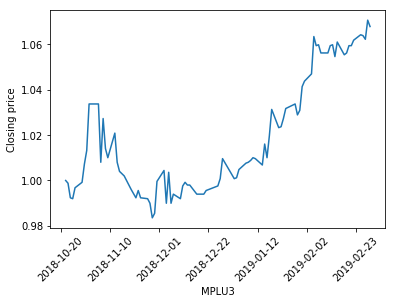

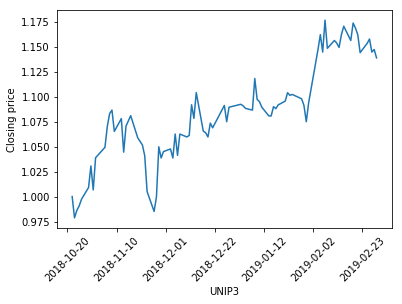

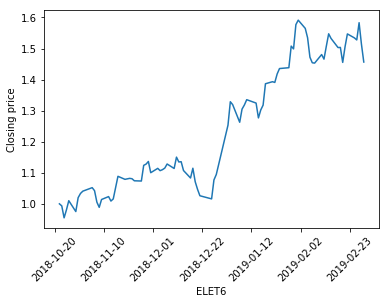

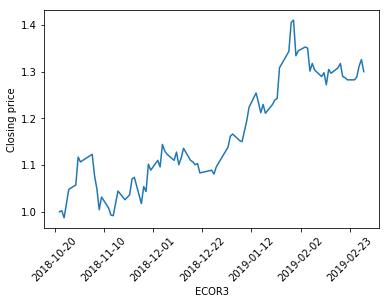

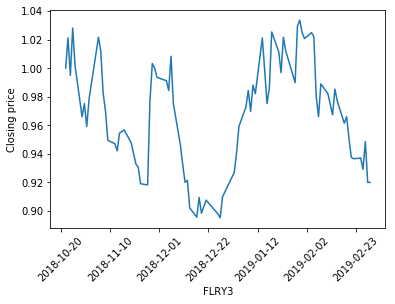

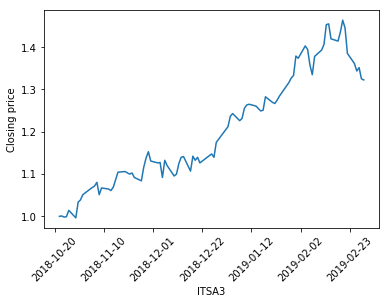

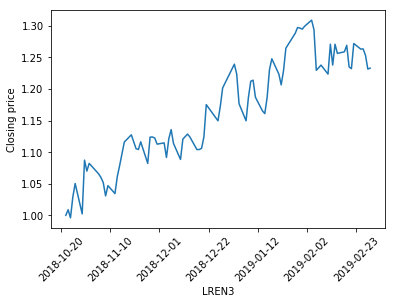

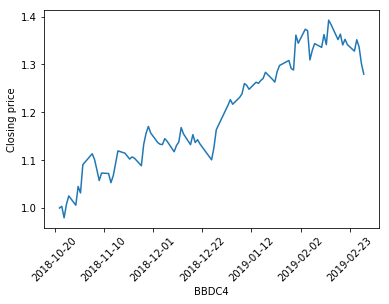

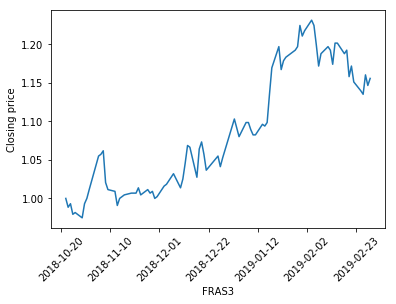

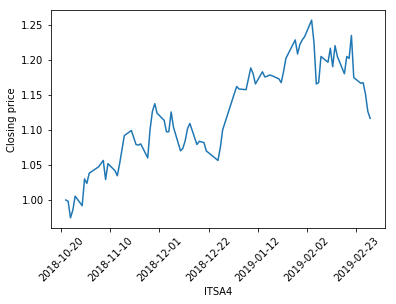

In [24]:
securities = df[labels]
first_row = securities.iloc[0]
ndf = securities / first_row
for label in ndf.columns.values:
    plt.figure()
    company = ndf[label]
    plt.ylabel('Closing price')
    plt.xlabel(company.name)
    plt.xticks(rotation=45)
    #plt.ylim(0, 100)
    plt.plot(ndf.index.values, company)

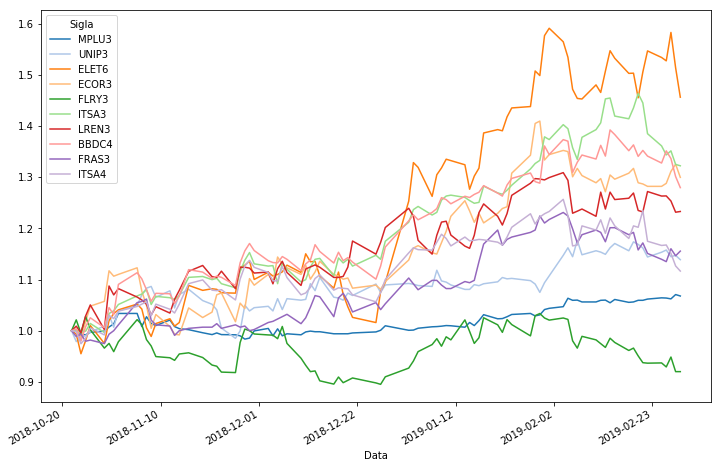

In [19]:
ndf.plot(figsize=(12, 8), color=cm.colors)
plt.show()

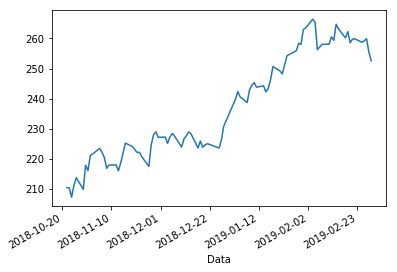

In [20]:

virtual_portfolio = securities.copy()

for (weight, asset) in labeled_percentages:
    virtual_portfolio[asset] = virtual_portfolio[asset] * weight / 100.0

portfolio = np.sum(virtual_portfolio, axis=1)
plt.figure()
portfolio.plot()

# plt.figure()
# new_virtual_portfolio = np.mean(virtual_portfolio, axis=1) * 250
# new_virtual_portfolio.plot()

# Lucro percentual e nominal

In [21]:
initial_value = portfolio.iloc[0]
current_value = portfolio.iloc[-1]
profit = current_value - initial_value
print(initial_value)
print(current_value)
print(profit)
print('Lucro nominal=%s; Lucro percentual=%s' % (profit, profit/initial_value))

210.4108
252.55
42.13920000000002
Lucro nominal=42.13920000000002; Lucro percentual=0.20027108874639524
